# Answering business questions using SQL

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

The Chinook database is provided as a SQLite database file called chinook.db. A copy of the database schema is below

<img src=https://s3.amazonaws.com/dq-content/280/chinook-schema.svg>

In [12]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We will start by creating a few helper functions to make query and command execution easier as we go forward. 

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT 
        name
    FROM 
        sqlite_master 
    WHERE 
        type IN ("table","view") 
        AND name NOT LIKE 'sqlite_%';
    '''
    return run_query(q)

In [3]:
show_tables()

,name
0,album
1,artist
2,customer
3,employee
4,genre
5,invoice
6,invoice_line
7,media_type
8,playlist
9,playlist_track


## Selecting albums to purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now.

| Artist Name | Genre|
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk | 
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [4]:
q = '''

WITH tracks_sold_usa AS (
    SELECT il.* 
    FROM invoice i
    INNER JOIN invoice_line il on i.invoice_id = il.invoice_id
    WHERE i.billing_country = 'USA'
)

SELECT 
    g.name genre_name, 
    COUNT(ts.invoice_line_id) num_tracks_sold, 
    CAST( COUNT(ts.invoice_line_id) AS FLOAT ) / 
        (SELECT COUNT(*) FROM tracks_sold_usa) pc_tracks_sold
FROM tracks_sold_usa ts
INNER JOIN track t ON ts.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id 
GROUP BY 1
ORDER BY 2 DESC;
'''

df = run_query(q)
df.head(10)

,genre_name,num_tracks_sold,pc_tracks_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


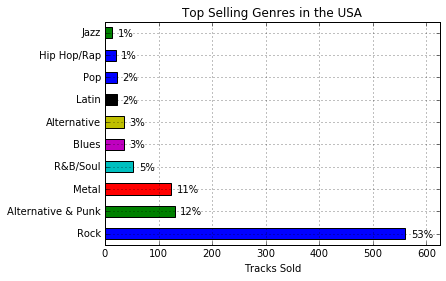

In [5]:
df = run_query(q)
df.set_index('genre_name', inplace=True, drop=True)

df['num_tracks_sold'].head(10).plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625)
)

plt.ylabel('')

for i, label in enumerate(list(df.index)):
    score = df.loc[label, "num_tracks_sold"]
    label = (df.loc[label, "pc_tracks_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.xlabel('Tracks Sold')
plt.grid()
plt.show()

Seeing the top 10 genres being sold through Chinook, Rock is the overwhelming majority, covering over 50%. From the distribution of the other genres, Red Tone seems like a good choice for the Punk genre and should perform well. Slim Jim Bites (Blues) may also do well, but further analysis is required between Meteor and the Girls (Pop), and Regal (Hip-Hop).

It would also be a good idea to keep a look-out for Rock genre based artists. 

## Analysing sales performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We can analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [6]:
q = '''

WITH total_purchases AS
    (
        SELECT 
            customer_id,
            SUM(total) total
        FROM invoice i
        GROUP BY customer_id
    )

SELECT 
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    SUM(tp.total) total_sales
FROM employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN total_purchases tp ON tp.customer_id = c.customer_id
GROUP BY c.support_rep_id
'''
run_query(q)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


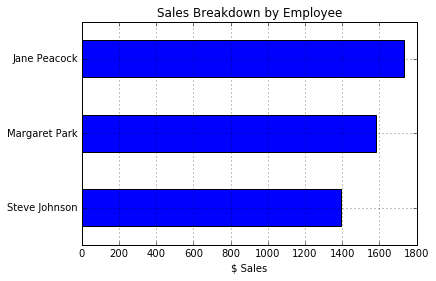

In [7]:
df = run_query(q)

df.set_index("employee_name", drop=True, inplace=True)
df.sort_values("total_sales", inplace=True)
df.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
)
plt.ylabel('')
plt.xlabel('$ Sales')
plt.grid()
plt.show()

We see the sales performance of our three support reps as shown. The agent with the least sales is $400 short of the top performer, however he also started 6 months later which may explain the gap. 

## Analysing sales by country

Next, we analyse the sales data for customers from each different country. In particular, we want to find the following information for each country:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [9]:
q = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
run_query(q)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


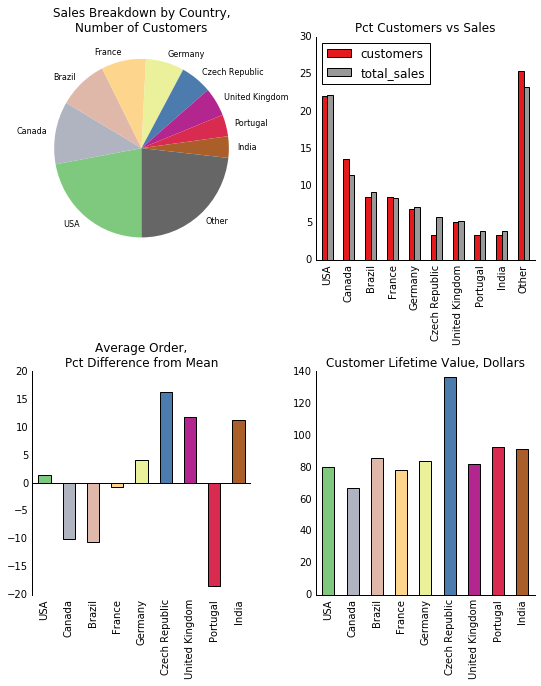

In [13]:
country_metrics = run_query(q)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

From this analysis, we can identify 3 potential markets for expansion:

1. Czech Republic
2. United Kingdom
3. India

All three of these markets currently make up a small proportion of the revenues, but have high average orders and customer values, indicating great potential growth. This analysis is based on a small amount of data, so pilot projects would be best to test out initially.

## Albums vs. individual tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

Therefore, we will try to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue. In this instance, we have two edge cases to consider:

1. Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
2. Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In [14]:
q = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, it would not be advisable allow purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

## Next steps

Here are some potential further questions we can answer using his data:

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?